In [1]:
import os
os.getcwd()

'/Users/rodrigocbbelchior/Desktop/NOVA_SBE/S2/T3/Advanced_Programming_for_Data_Science/GroupProject/group_03/Prototypes'

In [2]:
os.chdir('..')

In [3]:
import pandas as pd
import os
import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


/Users/rodrigocbbelchior/opt/anaconda3/envs/AdPro/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [47]:
"""
This file contains a class that analyzes agriculture data
from the Agricultural total factor productivity (USDA) dataset.

"""

# %load Class/agros_class.py
import os
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import geopandas as gpd
from pmdarima import auto_arima


class AgrosAnalysis:
    """
    A class for analyzing agriculture data from the Agricultural
    total factor productivity (USDA) dataset.

    Attributes
    ---------------
    url: str
        The URL of the crop data file.
    file_path: str
        The file path where the crop data file is saved.
    to_df: pandas.DataFrame
        The crop data loaded into a pandas DataFrame.

    """

    # Dictionary to match country names on geo_data and agros data
    merge_dict = {
        "Bosnia and Herz.": "Bosnia and Herzegovina",
        "Central African Rep.": "Central African Republic",
        "Dem. Rep. Congo": "Democratic Republic of Congo",
        "Dominican Rep.": "Dominican Republic",
        "Eq. Guinea": "Equatorial Guinea",
        "S. Sudan": "South Sudan",
        "Solomon Is.": "Solomon Islands",
        "Timor-Leste": "Timor",
        "United States of America": "United States",
    }

    def __init__(self, url: str):
        """
        Initializes a CropAnalysis object.

        Parameters
        ---------------
        url: str
            The URL of the crop data file.

        Raises
        ---------------
        ValueError
            The file must be the Agricultural total factor productivity (USDA) dataset.
        FileNotFoundError
            The user must be in the project's root directory.

        """
        url_string = (
            "https://raw.githubusercontent.com/owid/owid-datasets/master/"
            "datasets/Agricultural%20total%20factor%20productivity%20(USDA)"
            "/Agricultural%20total%20factor%20productivity%20(USDA).csv"
        )

        # The file must be the Agricultural total factor productivity (USDA) dataset
        if url != url_string:
            raise ValueError(
                "Wrong URL provided. You must provide the URL from "
                "the Agricultural total factor productivity (USDA) dataset"
            )

        # Must be in the project's root directory
        if os.getcwd().endswith("group_03"):
            self.url = url
            self.file_path = os.path.join(
                os.getcwd(), "downloads", "agriculture_data.csv"
            )
            self.to_df = None
        else:
            raise FileNotFoundError("You are not in the project's root directory")

    def download(self) -> None:
        """
        Downloads the crop data from the specified URL and saves it to a file.

        If the file already exists, the data is loaded from the file
        instead of downloading it again.

        Either way, the method creates a DataFrame using the "to_df" attribute.
        The DataFrame is cleaned to remove regions and only contain countries.

        """

        regions = [
            "Asia",
            "Caribbean",
            "Central Africa",
            "Central America",
            "Central Asia",
            "Central Europe",
            "Developed Asia",
            "Developed countries",
            "East Africa",
            "Eastern Europe",
            "Europe",
            "High income",
            "Horn of Africa",
            "Latin America and the Caribbean",
            "Least developed countries",
            "Low income",
            "Lower-middle income",
            "North Africa",
            "North America",
            "Northeast Asia",
            "Northern Europe",
            "Oceania",
            "Pacific",
            "South Asia",
            "Southeast Asia",
            "Southern Africa",
            "Southern Europe",
            "Sub-Saharan Africa",
            "Sahel",
            "Upper-middle income",
            "West Africa",
            "West Asia",
            "Western Europe",
            "World",
        ]

        if os.path.exists(self.file_path):
            data_frame = pd.read_csv(self.file_path)

        else:
            data_frame = pd.read_csv(self.file_path)
            os.makedirs(os.path.dirname(self.file_path), exist_ok=True)
            self.to_df.to_csv(self.file_path, index=False)

        # Removing regions from entity columns
        data_frame = data_frame[~data_frame["Entity"].isin(regions)]
        # Reading the geodata and renaming the countries
        geo_data = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")).replace(
            {"name": self.merge_dict}
        )
        # Merging the two datasets
        self.to_df = geo_data.merge(
            data_frame, how="inner", left_on="name", right_on="Entity"
        )

    def countries(self) -> list[str]:
        """
        Returns a list of unique countries in the data frame.

        Returns
        ---------------
        countries_list: list[string]
            The list of unique countries in the data frame.

        """
        countries_list = self.to_df["Entity"].unique().tolist()
        return countries_list

    def corr_matrix(self) -> sns.matrix.ClusterGrid:
        """
        Plots a heatmap correlation of the "_quantity" columns.

        Returns
        ---------------
        corr_plot: sns.matrix.ClusterGrid
            The heatmap correlation of the "_quantity" columns.

        """
        quantity_df = self.to_df.loc[:, self.to_df.columns.str.contains("_quantity")]

        # Correlation between different variables
        corr = quantity_df.corr()
        # Set up the matplotlib plot configuration
        plt.subplots(figsize=(12, 10))
        # Generate a mask for upper triangle
        mask = np.triu(np.ones_like(corr, dtype=bool))
        # Configure a custom diverging colormap
        cmap = sns.diverging_palette(230, 20, as_cmap=True)
        # Plot the heatmap
        corr_plot = sns.heatmap(corr, annot=True, mask=mask, cmap=cmap)
        # Add source to plot
        plt.annotate(
            "Source: Agricultural total factor productivity (USDA)",
            (0, 0),
            (0, -150),
            fontsize=8,
            xycoords="axes fraction",
            textcoords="offset points",
            va="bottom",
        )
        return corr_plot

    def area_chart(self, country: str, normalize: bool):
        """
        Create an area chart for the '_output_' columns for a specific country or all countries.
        This chart can be normalized or not according to the "normalize" parameter.

        Parameters
        ---------------
        country: str
            Represents the country to plot the data for.
            If None or 'World', the data for all countries will be plotted.
        normalize: bool
            Indicates whether to normalize the data.

        Raises
        ---------------
        ValueError
            The given country must exist in the data.

        """

        # Check if the given country exists in the data, or is Null or 'World'
        if (
            country is not None
            and country != "World"
            and country not in self.to_df["Entity"].unique()
        ):
            raise ValueError(f"Country {country} does not exist in the data.")

        # Subset the data to the selected country or all countries
        if country is None or country == "World":
            data = (
                self.to_df.groupby("Year")
                .sum()[
                    [
                        "fish_output_quantity",
                        "crop_output_quantity",
                        "animal_output_quantity",
                        "output_quantity",
                    ]
                ]
                .reset_index()
            )
        else:
            data = self.to_df[self.to_df["Entity"] == country][
                [
                    "Year",
                    "fish_output_quantity",
                    "crop_output_quantity",
                    "animal_output_quantity",
                    "output_quantity",
                ]
            ]

        # Normalize the data if necessary
        if normalize:
            outputs = [
                "fish_output_quantity",
                "crop_output_quantity",
                "animal_output_quantity",
            ]

            for output in outputs:
                data[output] = data[output] / data["output_quantity"] * 100
            title = "(Normalized)"
            # set the index to the year column
            area_df = data.set_index("Year")
        else:
            area_df = data.set_index("Year")
            title = ""

        # Create the area chart
        plt.stackplot(
            data["Year"],
            data["fish_output_quantity"],
            data["crop_output_quantity"],
            data["animal_output_quantity"],
            labels=area_df.columns,
            colors=["Cyan", "Darkgreen", "Red"],
        )
        plt.xlabel("Year")
        plt.ylabel("Output")
        plt.title(
            f'Agriculture Output for {country if country is not None else "World"} {title}'
        )
        plt.legend(loc="upper left")
        plt.annotate(
            "Source: Agricultural total factor productivity (USDA)",
            (0, 0),
            (0, -50),
            fontsize=8,
            xycoords="axes fraction",
            textcoords="offset points",
            va="bottom",
        )
        plt.show()

    def comparison_chart(self, countries: str or list[str]):
        """
        Plot a comparison of the '_output_' columns for the countries provided.
        Creates three plots to compare each country to each type of output.
        Only creates one plot if only one country is provided.

        Parameters
        ---------------
        countries: str or list[str]
            Contains the country/countries to plot the data for.

        Raises
        ---------------
        ValueError
            The given countries must exist in the data.

        """

        # Convert the countries input to a list if it's a string
        if isinstance(countries, str):
            countries = [countries]

        # Check if all of the given countries exist in the data
        if not set(countries).issubset(set(self.to_df["Entity"].unique())):
            invalid_countries = set(countries) - set(self.to_df["Entity"].unique())
            raise ValueError(
                f"The following countries do not exist in the data: {invalid_countries}"
            )

        # Subset the data to the selected countries
        outputs = [
            "fish_output_quantity",
            "crop_output_quantity",
            "animal_output_quantity",
        ]

        # create a scatter plot with size based on 'land_area'
        if len(countries) == 1:
            data = (
                self.to_df[self.to_df["Entity"].isin(countries)]
                .groupby(["Year", "Entity"])
                .sum()[outputs]
                .unstack()
            )
            data.columns = data.columns.droplevel()

            # Plot the comparison chart
            data.plot(kind="line")
            plt.xlabel("Year")
            plt.ylabel("Output")
            plt.title(f'Agriculture Output Comparison for {", ".join(countries)}')
            plt.legend(loc="upper left", labels=outputs)
            plt.annotate(
                "Source: Agricultural total factor productivity (USDA)",
                (0, 0),
                (0, -50),
                fontsize=8,
                xycoords="axes fraction",
                textcoords="offset points",
                va="bottom",
            )
            plt.show()

        else:
            for output in outputs:
                sub_string = output.split("_")
                data = (
                    self.to_df[self.to_df["Entity"].isin(countries)]
                    .groupby(["Year", "Entity"])
                    .sum()[[output]]
                    .unstack()
                )
                data.columns = data.columns.droplevel()

                # Plot the comparison chart
                data.plot(kind="line")
                plt.xlabel("Year")
                plt.ylabel("Output")
                plt.title(
                    f'{sub_string[0].capitalize()} Output Comparison for {", ".join(countries)}'
                )
                plt.legend(loc="upper left")
                plt.annotate(
                    "Source: Agricultural total factor productivity (USDA)",
                    (0, 0),
                    (0, -50),
                    fontsize=8,
                    xycoords="axes fraction",
                    textcoords="offset points",
                    va="bottom",
                )
                plt.show()

    def gapminder(self, year: int):
        """
        Create a scatter plot for fertilizer quantity and output quantity, using the
        "cropland_quantity" variable for the size of the dots. Each dot represents a country.
        Log-scale is being used to help visualization.

        Parameters
        ---------------
        year: int
            The year to plot the data for.

        Raises
        ---------------
        TypeError
            The year argument must be an integer.

        """

        # check that the year argument is an integer
        if not isinstance(year, int):
            raise TypeError("Year argument must be an integer")

        # subset the data to the given year and drop any rows with missing values
        data = self.to_df[self.to_df["Year"] == year].dropna(
            subset=["fertilizer_quantity", "output_quantity"]
        )

        plt.scatter(
            data["fertilizer_quantity"],
            data["output_quantity"],
            s=np.log(data["cropland_quantity"]) * 10,
            alpha=0.4,
            label="Cropland Quantity",
        )
        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel("Fertilizer Quantity")
        plt.ylabel("Output Quantity")
        plt.legend(labels=["Cropland Quantity"])
        plt.title(f"Agriculture Scatter Plot for {year}")
        plt.annotate(
            "Source: Agricultural total factor productivity (USDA)",
            (0, 0),
            (0, -50),
            fontsize=8,
            xycoords="axes fraction",
            textcoords="offset points",
            va="bottom",
        )
        plt.show()

    def choropleth(self, year: int):
        """
        Creates a choropleth plot for the TFP (total factor productivity).

        Parameters
        ---------------
        year: int
            The year to plot the data for.

        Raises
        ---------------
        TypeError
            The year argument must be an integer.

        """

        # check that the year argument is an integer
        if not isinstance(year, int):
            raise TypeError("Year argument must be an integer")

        # subset the data to the given year and drop any rows with missing values
        data = self.to_df[self.to_df["Year"] == year]

        # Plot the choropleth
        a_x = plt.subplots(figsize=(10, 6))[1]
        data.plot(cmap="Greens", column="tfp", linewidth=0.8, ax = a_x, edgecolor="0.6")
        a_x.axis("off")
        a_x.set_title("Choropleth Map")

        # Add a colorbar
        vmin = data["tfp"].min()
        vmax = data["tfp"].max()
        s_m = plt.cm.ScalarMappable(
            cmap="Greens", norm=plt.Normalize(vmin=vmin, vmax=vmax)
        )
        s_m.set_array([])
        cbar = plt.colorbar(s_m, shrink=0.5, alpha=0.8)
        cbar.ax.set_title("TFP")
        plt.show()

    def predictor(self, countries: list[str]):
        """
        Creates a line plot with the past and predicted values until 2050 for each of the
        selected countries using ARIMA for the prediction.

        Parameters
        ---------------
        countries: list[str]
            A list of up to 3 countries.

        Raises
        ---------------
        ValueError
            The input list must have a maximum length of 3.
        TypeError
            The input type must be a list.
        ValueError
            At least one of the countries must have a valid name.


        """

        if len(countries) > 3:
            raise ValueError("The input list must have a maximum length of 3")

        if not isinstance(countries, list):
            raise TypeError("The input type must be a list.")

        invalid_countries = set(countries) - set(self.to_df["Entity"].unique())
        valid_countries = list(set(countries) - invalid_countries)

        if len(invalid_countries) == 3:
            raise ValueError(
                f"The following countries do not exist in the data:\n {invalid_countries}\n"
                f"\nThese are the available countries:\n {self.countries()}"
            )

        # Ignore the warnings, as some parameters may be incompatible with some ARIMA settings
        warnings.filterwarnings("ignore")

        # Color list
        colors = ["Green", "Blue", "Orange"]
        i = 0

        while i < len(valid_countries):
            for country in valid_countries:
                color = colors[i]

                # Dataframe with past data for the country
                past_df = self.to_df[self.to_df["Entity"] == country][["tfp"]]
                past_df.head()
                past_df["Time"] = pd.date_range(
                    start=str(self.to_df[["Year"]].min()[0]) + "-01-01",
                    periods=self.to_df[["Year"]].max()[0]
                    - (self.to_df[["Year"]].min()[0])
                    + 1,
                    freq="Y",
                )

                stepwise_fit = auto_arima(
                    self.to_df[self.to_df["Entity"] == country][["tfp"]],
                    start_p=1,
                    start_q=1,
                    max_p=3,
                    max_q=3,
                    m=1,
                    start_P=0,
                    seasonal=False,
                    d=None,
                    D=1,
                    error_action="ignore",  # Ignore incompatible settings
                    suppress_warnings=True,
                    stepwise=True,
                )

                # Dataframe with prediction data
                prediction = pd.DataFrame(
                    stepwise_fit.predict(
                        n_periods=2050 - int(self.to_df[["Year"]].max()[0] + 1)
                    )
                )  # , index=dair.index)
                prediction["Time"] = pd.date_range(
                    start=str(self.to_df[["Year"]].max()[0] + 1) + "-01-01",
                    periods=2050 - (self.to_df[["Year"]].max()[0] + 1),
                    freq="Y",
                )
                # Plots
                plt.plot(past_df["Time"], past_df["tfp"], c=color, label=country)
                plt.plot(
                    prediction["Time"],
                    prediction.iloc[:, 0],
                    linestyle="dotted",
                    c=color,
                    label=f"{country} predicted",
                )
                plt.xlabel("Year")
                plt.ylabel("TFP")
                plt.legend(loc="upper left")
                plt.title("Past and predicted TFP by country")
                plt.annotate(
                    "Source: Agricultural total factor productivity (USDA)",
                    (0, 0),
                    (0, -50),
                    fontsize=8,
                    xycoords="axes fraction",
                    textcoords="offset points",
                    va="bottom",
                )

                # Iterate through color list
                i += 1


In [48]:
ba = AgrosAnalysis("https://raw.githubusercontent.com/owid/owid-datasets/master/datasets/Agricultural%20total%20factor%20productivity%20(USDA)/Agricultural%20total%20factor%20productivity%20(USDA).csv")

In [49]:
ba.download()
#auto_arima()

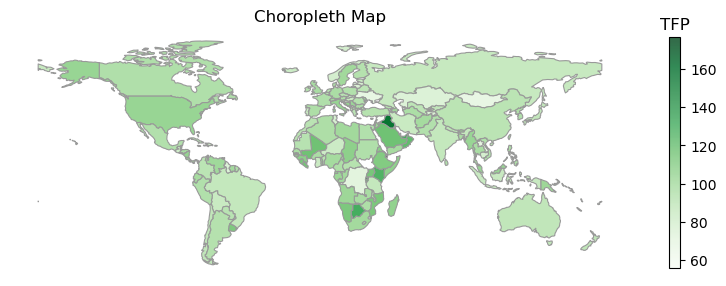

In [50]:
ba.choropleth(2010)

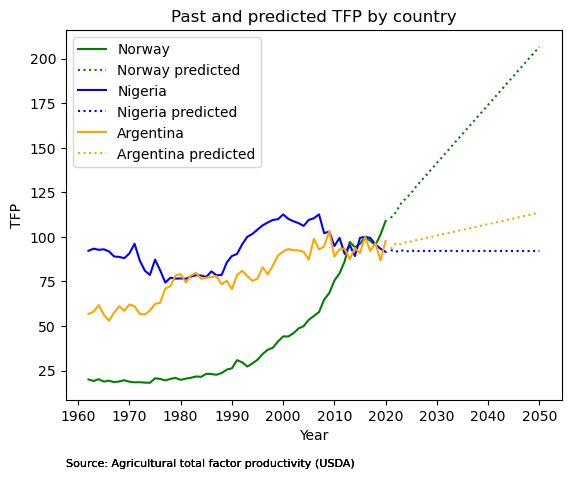

In [51]:
ba.predictor(["Norway","Nigeria","Argentina"])

In [188]:
#type(ba.to_df[["Year"]].max())

df = pd.DataFrame()
df = pd.date_range(start= "2020-01-01", periods = 31, freq='Y')


df

DatetimeIndex(['2020-12-31', '2021-12-31', '2022-12-31', '2023-12-31',
               '2024-12-31', '2025-12-31', '2026-12-31', '2027-12-31',
               '2028-12-31', '2029-12-31', '2030-12-31', '2031-12-31',
               '2032-12-31', '2033-12-31', '2034-12-31', '2035-12-31',
               '2036-12-31', '2037-12-31', '2038-12-31', '2039-12-31',
               '2040-12-31', '2041-12-31', '2042-12-31', '2043-12-31',
               '2044-12-31', '2045-12-31', '2046-12-31', '2047-12-31',
               '2048-12-31', '2049-12-31', '2050-12-31'],
              dtype='datetime64[ns]', freq='A-DEC')

In [409]:
ba.to_df[["Year"]].max()[0] - ba.to_df[["Year"]].min()[0]

#print(2050 - ba.to_df[["Year"]].max()[0])

58

In [28]:
merge_dict = {
    "Bosnia and Herz." : "Bosnia and Herzegovina",
    "Central African Rep." : "Central African Republic",
    "Dem. Rep. Congo" : "Democratic Republic of Congo",
    "Dominican Rep." : "Dominican Republic",
    "Eq. Guinea" : "Equatorial Guinea",
    "S. Sudan" : "South Sudan",
    "Solomon Is." : "Solomon Islands",
    "Timor-Leste" : "Timor",
    "United States of America" : "United States"
}

test.replace({"name": merge_dict})

            

pop_est      continent                 name iso_a3  gdp_md_est  \
0       889953.0        Oceania                 Fiji    FJI        5496   
1     58005463.0         Africa             Tanzania    TZA       63177   
2       603253.0         Africa            W. Sahara    ESH         907   
3     37589262.0  North America               Canada    CAN     1736425   
4    328239523.0  North America        United States    USA    21433226   
..           ...            ...                  ...    ...         ...   
172    6944975.0         Europe               Serbia    SRB       51475   
173     622137.0         Europe           Montenegro    MNE        5542   
174    1794248.0         Europe               Kosovo    -99        7926   
175    1394973.0  North America  Trinidad and Tobago    TTO       24269   
176   11062113.0         Africa          South Sudan    SSD       11998   

                                              geometry  
0    MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1    POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2    POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3    MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4    MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  
..                                                 ...  
172  POLYGON ((18.82982 45.90887, 18.82984 45.90888...  
173  POLYGON ((20.07070 42.58863, 19.80161 42.50009...  
174  POLYGON ((20.59025 41.85541, 20.52295 42.21787...  
175  POLYGON ((-61.68000 10.76000, -61.10500 10.890...  
176  POLYGON ((30.83385 3.50917, 29.95350 4.17370, ...  

[177 rows x 6 columns]

In [141]:
 prediction.head() 

NameError: name 'prediction' is not defined

In [21]:
geo_data["name"].sort_values().to_list()

['Afghanistan',
 'Albania',
 'Algeria',
 'Angola',
 'Antarctica',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bangladesh',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herz.',
 'Botswana',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Rep.',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Congo',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 "Côte d'Ivoire",
 'Dem. Rep. Congo',
 'Denmark',
 'Djibouti',
 'Dominican Rep.',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Eq. Guinea',
 'Eritrea',
 'Estonia',
 'Ethiopia',
 'Falkland Is.',
 'Fiji',
 'Finland',
 'Fr. S. Antarctic Lands',
 'France',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Greenland',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',
 'Haiti',
 'Honduras',
 'Hungary',
 'Iceland',
 'India',
 'Indonesia',
 'Iran',
 'Iraq',
 'Ireland',
 'Israel',
 'Italy

In [22]:
ba.countries()

['Afghanistan',
 'Albania',
 'Algeria',
 'Angola',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Czechoslovakia',
 'Democratic Republic of Congo',
 'Denmark',
 'Djibouti',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Fiji',
 'Finland',
 'Former Soviet Union',
 'France',
 'French Guiana',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',
 'Haiti',
 'Honduras',
 'Hungary',
 'Iceland',
 'India',
 'Indo

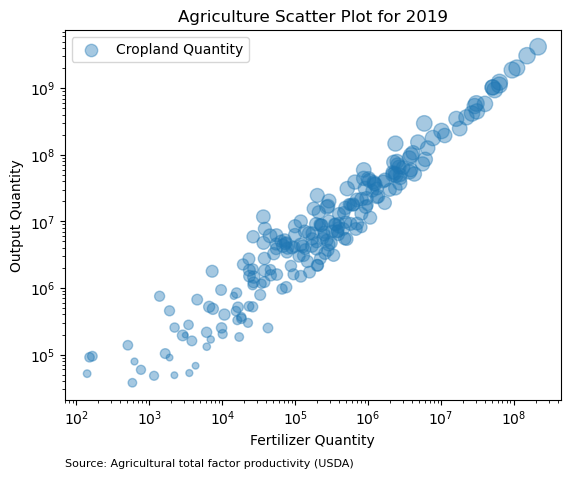

In [30]:
ba.gapminder(2019)

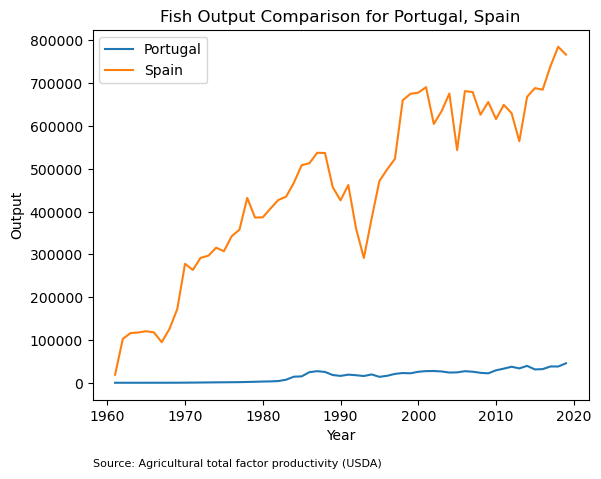

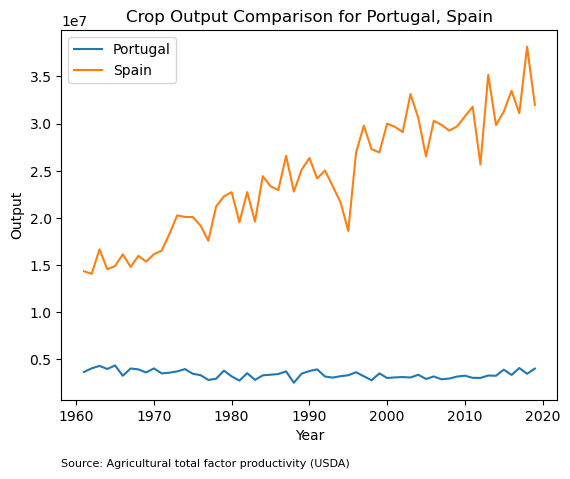

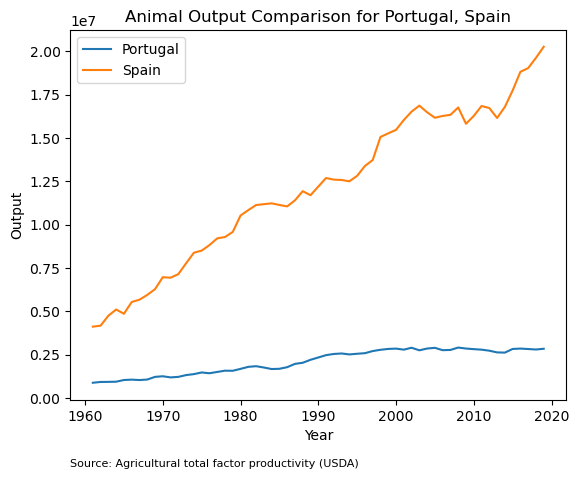

In [32]:
ba.comparison_chart(["Portugal", "Spain"])

C:\Users\atdac\AppData\Local\Temp\ipykernel_70828\1688379668.py:157: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .sum()[


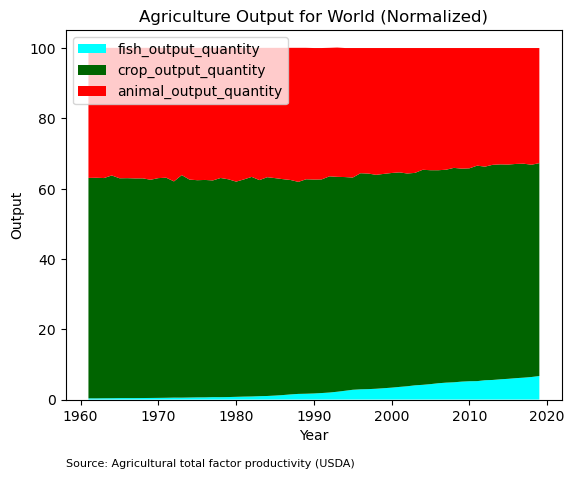

In [31]:
ba.area_chart(None, True)

In [488]:
os.chdir('/Users/rodrigocbbelchior/Desktop/NOVA_SBE/S2/T3/Advanced_Programming_for_Data_Science/GroupProject/group_03/')

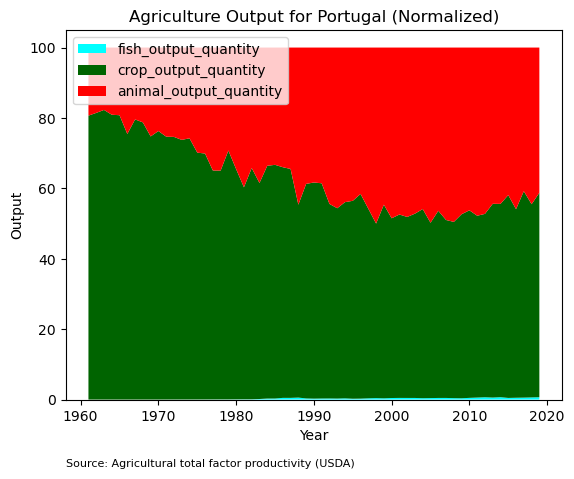

In [26]:
ba.area_chart("Portugal",True)

<AxesSubplot: >

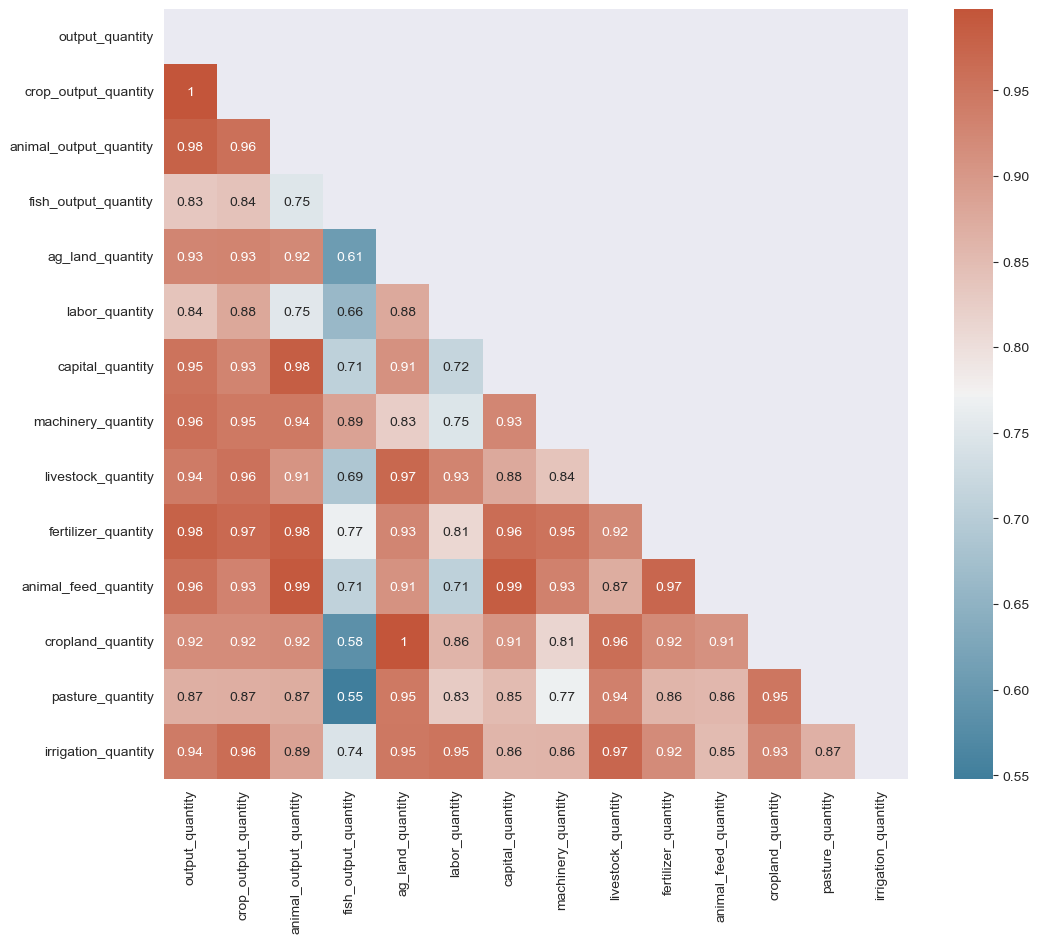

In [502]:
ba.corr_matrix()

<AxesSubplot: >

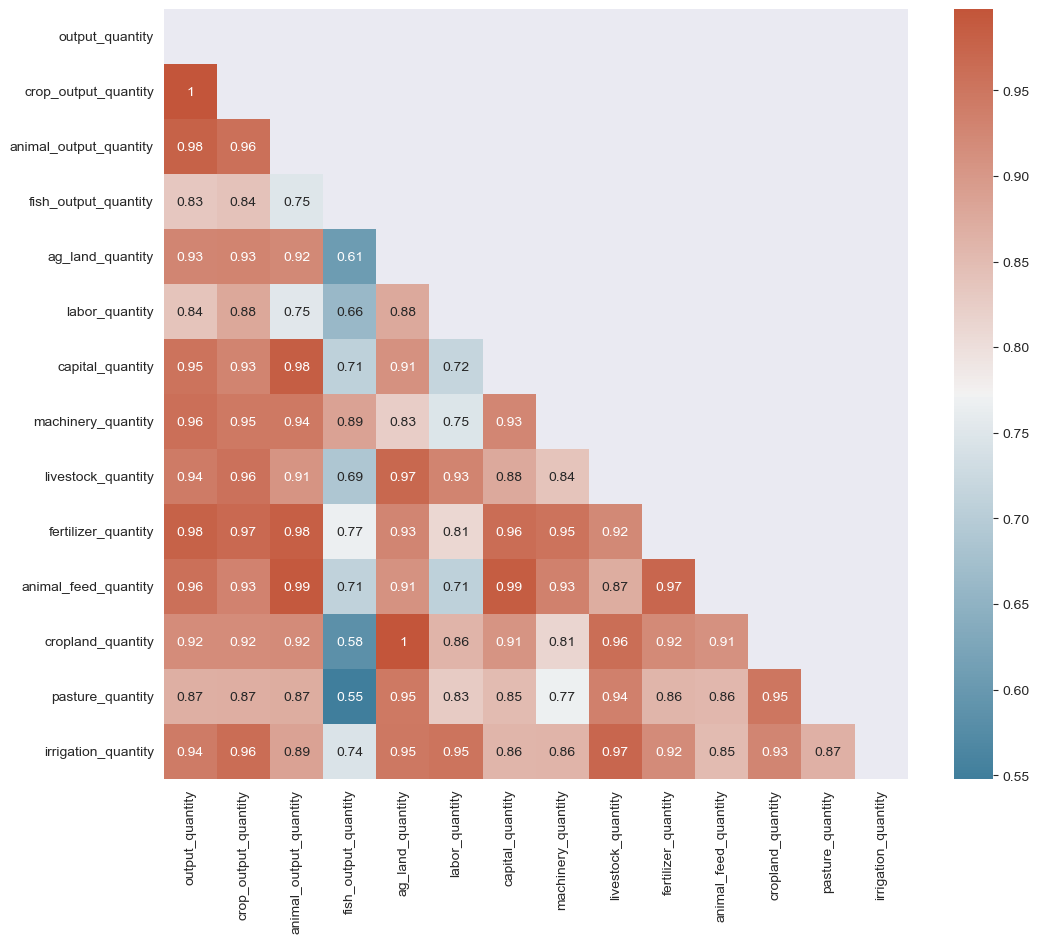

In [454]:
agros.corr_plot()

In [188]:
ok[ok["Entity"] == "Portugal"][["Year","output",'fish_output_quantity', 'crop_output_quantity','animal_output_quantity']]

Year    output  fish_output_quantity  crop_output_quantity  \
8773  1961   66.8707                     0               3629379   
8774  1962   73.3268                     0               4017904   
8775  1963   77.2170                     0               4274991   
8776  1964   72.5270                     0               3948881   
8777  1965   79.5134                     5               4321758   
8778  1966   63.5867                    14               3228171   
8779  1967   74.7349                    38               4002130   
8780  1968   73.7134                    75               3905150   
8781  1969   71.1548                   113               3578777   
8782  1970   78.0648                   221               4006900   
8783  1971   69.2022                   372               3477248   
8784  1972   70.7921                   560               3553767   
8785  1973   74.4149                   729               3693066   
8786  1974   78.8659                   955               3937590   
8787  1975   72.8775                  1091               3438784   
8788  1976   70.0398                  1247               3292490   
8789  1977   63.5581                  1454               2781548   
8790  1978   66.6022                  1858               2912608   
8791  1979   79.3009                  2310               3772380   
8792  1980   71.8725                  2832               3162092   
8793  1981   66.9515                  3223               2713042   
8794  1982   79.3003                  3967               3506130   
8795  1983   67.5820                  7135               2790309   
8796  1984   73.5408                 14191               3272194   
8797  1985   74.7399                 14885               3338593   
8798  1986   77.3549                 24787               3410890   
8799  1987   84.4106                 27096               3693737   
8800  1988   67.3933                 25268               2485066   
8801  1989   84.2058                 18082               3453137   
8802  1990   90.2689                 16014               3729851   
8803  1991   94.9419                 18948               3906092   
8804  1992   84.6866                 17604               3149312   
8805  1993   83.3417                 15731               3032182   
8806  1994   84.7622                 19463               3179222   
8807  1995   86.8111                 13806               3284040   
8808  1996   92.0889                 16326               3603387   
8809  1997   87.6015                 20682               3174512   
8810  1998   82.3956                 22732               2749264   
8811  1999   93.9684                 22097               3478300   
8812  2000   87.0236                 25698               2989795   
8813  2001   87.1172                 27189               3054269   
8814  2002   89.2633                 27403               3088431   
8815  2003   86.3817                 26449               3043337   
8816  2004   92.1657                 23840               3332537   
8817  2005   86.1403                 24302               2886838   
8818  2006   88.1277                 27015               3152675   
8819  2007   83.8521                 25804               2852358   
8820  2008   87.0621                 23227               2933407   
8821  2009   89.2844                 22027               3141144   
8822  2010   90.2962                 29122               3237028   
8823  2011   86.4909                 32995               3006233   
8824  2012   85.5376                 37425               2998367   
8825  2013   87.8028                 33600               3252048   
8826  2014   87.3182                 39467               3226589   
8827  2015  100.0000                 31180               3877425   
8828  2016   91.9827                 31828               3315250   
8829  2017  102.5853                 38061               4048305   
8830  2018   93.1368                 38004               34397

In [220]:
len("oi")

2

In [232]:
ok

Entity  Year       tfp    output    inputs  ag_land_index  \
0      Afghanistan  1961   65.0814   44.8285   68.8807        91.6812   
1      Afghanistan  1962   64.0637   45.6182   71.2075        92.2016   
2      Afghanistan  1963   61.6217   45.9729   74.6051        92.6352   
3      Afghanistan  1964   65.1109   49.0775   75.3752        93.1816   
4      Afghanistan  1965   63.8587   51.2121   80.1960        93.1990   
...            ...   ...       ...       ...       ...            ...   
12177     Zimbabwe  2015  100.0000  100.0000  100.0000       100.0000   
12178     Zimbabwe  2016   94.8110   98.1051  103.4744       103.8526   
12179     Zimbabwe  2017  101.9830  104.9815  102.9402        99.6960   
12180     Zimbabwe  2018  118.1959  121.0832  102.4428       102.8520   
12181     Zimbabwe  2019  114.9524  114.2108   99.3549        92.5939   

       labor_index  capital_index  materials_index  output_quantity  ...  \
0          44.5145       141.5215          35.9132          2566730  ...   
1          45.0207       163.6547          36.3829          2611942  ...   
2          45.5528       202.0577          37.0801          2632254  ...   
3          46.1108       203.8875          37.5294          2810010  ...   
4          46.6948       270.9746          38.5949          2932230  ...   
...            ...            ...              ...              ...  ...   
12177     100.0000       100.0000         100.0000          2191374  ...   
12178     101.2662        97.9759         128.2406          2149850  ...   
12179     102.3605        96.4853         141.3410          2300538  ...   
12180     103.4662        95.3222         124.3694          2653386  ...   
12181     105.7368        94.1207         125.9910          2502786  ...   

       ag_land_quantity  labor_quantity  capital_quantity  machinery_quantity  \
0                 10571            1704              8866                   5   
1                 10631            1723             10253                   6   
2                 10681            1743             12659                   8   
3                 10744            1765             12773                   8   
4                 10746            1787             16976                  12   
...                 ...             ...               ...                 ...   
12177              2574            4184              8379                1154   
12178              2673            4237              8210                1174   
12179              2566            4283              8085                1180   
12180              2647            4330              7987                1201   
12181              2383            4425              7887                1210   

       livestock_quantity  fertilizer_quantity  animal_feed_quantity  \
0                    6339                57345               2068912   
1                    6228                58146               2082012   
2                    6547                59694               2007829   
3                    6732                60006               2140272   
4                    6946                61821               2171226   
...                   ...                  ...                   ...   
12177                5654                93807                975873   
12178                5705               146857               1000004   
12179                5601               160356               1113784   
12180                5681               146379                940395   
12181                5784               147631                957427   

       cropland_quantity  pasture_quantity  irrigation_quantity  
0                   7700             30000                 2380  
1                   7760             30000                 2380  
2                   7810             30000                 2380  
3                   7873             30000                 2380  
4                   7875             30000            

In [297]:
quantity_df = ok.loc[:, agros.df.columns.str.contains('_quantity')]
        
        # Correlation between different variables
corr = quantity_df.corr()
corr

ok.corr()

/var/folders/1z/f3l2cp3s7gd4vvlfscrnm1g80000gn/T/ipykernel_52016/305573259.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ok.corr()


Year       tfp    output    inputs  ag_land_index  \
Year                    1.000000  0.276645  0.551345  0.349193       0.212458   
tfp                     0.276645  1.000000  0.493373 -0.081697       0.026948   
output                  0.551345  0.493373  1.000000  0.762186       0.591019   
inputs                  0.349193 -0.081697  0.762186  1.000000       0.695742   
ag_land_index           0.212458  0.026948  0.591019  0.695742       1.000000   
labor_index            -0.161100 -0.171523  0.369652  0.645898       0.496250   
capital_index           0.493490  0.028708  0.594353  0.652529       0.362727   
materials_index         0.312273  0.049059  0.614158  0.713607       0.378013   
output_quantity         0.088959 -0.053870  0.028849  0.063511       0.038147   
crop_output_quantity    0.086105 -0.058344  0.014175  0.046757       0.028297   
animal_output_quantity  0.080554 -0.053977  0.047872  0.092212       0.055107   
fish_output_quantity    0.140796  0.013381  0.061835  0.048263       0.028410   
ag_land_quantity        0.013416 -0.105810 -0.034708  0.026826       0.018727   
labor_quantity          0.017994 -0.109015 -0.088980 -0.046721      -0.025199   
capital_quantity        0.068768 -0.061919  0.049340  0.103116       0.057753   
machinery_quantity      0.098717 -0.038517  0.057319  0.092798       0.056635   
livestock_quantity      0.035001 -0.092891 -0.039848  0.006884       0.002909   
fertilizer_quantity     0.068196 -0.067312  0.037025  0.092234       0.054576   
animal_feed_quantity    0.072286 -0.058501  0.054513  0.105862       0.063814   
cropland_quantity       0.005866 -0.109580 -0.034470  0.031071       0.019237   
pasture_quantity       -0.004665 -0.101550 -0.063490 -0.011042      -0.007641   
irrigation_quantity     0.051889 -0.088204 -0.035822  0.005375       0.010762   

                        labor_index  capital_index  materials_index  \
Year                      -0.161100       0.493490         0.312273   
tfp                       -0.171523       0.028708         0.049059   
output                     0.369652       0.594353         0.614158   
inputs                     0.645898       0.652529         0.713607   
ag_land_index              0.496250       0.362727         0.378013   
labor_index                1.000000       0.145966         0.314360   
capital_index              0.145966       1.000000         0.438561   
materials_index            0.314360       0.438561         1.000000   
output_quantity            0.022832       0.017229         0.023605   
crop_output_quantity       0.012193       0.000247         0.011418   
animal_output_quantity     0.045245       0.042775         0.043775   
fish_output_quantity      -0.006446       0.039525         0.024542   
ag_land_quantity           0.015330      -0.036346        -0.005424   
labor_quantity            -0.025754      -0.107099        -0.057734   
capital_quantity           0.059538       0.058783         0.043394   
machinery_quantity         0.044446       0.045498         0.044274   
livestock_quantity        -0.004799      -0.038645        -0.020553   
fertilizer_quantity        0.052549       0.023709         0.043889   
animal_feed_quantity       0.057639       0.048781         0.055673   
cropland_quantity          0.022167      -0.034566        -0.002074   
pasture_quantity          -0.011678      -0.040802        -0.029296   
irrigation_quantity       -0.011408      -0.049642        -0.019641   

                        output_quantity  crop_output_quantity  ...  \
Year                           0.088959              0.086105  ...   
tfp                           -0.053870             -0.058344  ...   
output                         0.028849              0.014175  ...   
inputs                         0.063511              0.046757  ...   
ag_land_index                  0.038147              0.028297  ...   
labor_index                    0.022832              0.012193  ...   
capital_index                  0.017229 